# Analysis of the autism data

Template exp:
Records n 7 

In [1]:
run init.ipynb

Done.


# Retrieve experiments results

In [9]:
from utils import create_autism_df
def compute_SD(AUC, N1, N2):
    Q1=AUC/(2-AUC)
    Q2 = 2*AUC*AUC/(1+AUC)
    return(np.sqrt((AUC*(1-AUC)+(N1-1)*(Q1-AUC*AUC) + (N2-1)*(Q2-AUC*AUC))/(N1*N2)))

df = create_autism_df(folder_names = ['8_December'])#'13_november_bis'])#'November 2022'])
df['Hanley_CI'] = df['AUROC'] .apply(lambda x: compute_SD(x, 417, 50))
df['tree_usage'] = df['tree_usage'].apply(lambda x: np.mean(x))

100%|██████████| 1851/1851 [08:36<00:00,  3.58it/s]


In [10]:
df.to_csv('/home01/sam/notes_on_stats/doc/src/data/8_December/recap.csv', index=False)

In [11]:
results_df_vertical = pd.DataFrame(columns = ['experiment_name', 'imputation_method', 'missing_data_handling', 'scale_data', 'n_features', 
                                              'sampling_method', 'max_depth',  'gamma', 'reg_lambda', 'learning_rate', 'n_estimators',
                                              'score', 'metric_name', 'TP', 'TN', 'FP', 'FN', 'y_true', 'y_pred', 'Hanley_CI'])

metrics_of_interest = ['AUROC', 'F1 score Corrected', 'Sensitivity', 'Specificity','PPV-Corr', 'TP', 'TN', 'FP', 'FN', 'Hanley_CI']
metrics_to_plot = ['AUROC', 'F1 score Corrected', 'Sensitivity', 'Specificity', 'PPV-Corr']#, 'Precision Corrected']

for exp, experiment_row in df.iterrows():
    
    for metric in metrics_of_interest:
        
        results_df_vertical = results_df_vertical.append({'experiment_name':experiment_row['experiment_name'], 
                                                                       'imputation_method':experiment_row['imputation_method'], 
                                                                       'missing_data_handling':experiment_row['missing_data_handling'], 
                                                                       'scale_data':experiment_row['scale_data'], 
                                                                       'n_features': experiment_row['n_features'], 
                                                                       'sampling_method': experiment_row['sampling_method'], 
                                                                       'max_depth': experiment_row['max_depth'], 
                                                                       'n_estimators': experiment_row['n_estimators'], 
                                                                       'gamma': experiment_row['gamma'], 
                                                                       'reg_lambda': experiment_row['reg_lambda'], 
                                                                       'learning_rate': experiment_row['learning_rate'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'y_true': [experiment_row['y_true']], 
                                                                       'y_pred': [experiment_row['y_pred']], 
                                                                       'Hanley_CI': experiment_row['Hanley_CI'], 
                                                                      }, ignore_index=True)
        
results_df_vertical.loc[results_df_vertical['metric_name']!='AUROC', 'Hanley_CI'] = 0

In [41]:
df = df.append(pd.DataFrame({'experiment_name': 'EyeTracker', 
                             'Specificity': .98, 
                             'Sensitivity':.17 , 
                             'PPV': .81, 
                             'NPV': .65
                            }, index=[0]))



##### Ploting Functions

In [12]:
def plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False, savefig=False):
    
    colors = plt.get_cmap('tab10')(np.arange(0,20))

    
    if xtickslabels is None:
        xtickslabels = sorted(results[condition].unique())
        
    if order is None:
        order = sorted(results[condition].unique())
        
    else:
        xtickslabels = order


    fig = plt.figure(figsize=(25, 8));ax = plt.gca()
    # loop over the curves (i.e. the metrics to be plotted)
    for j, metric_name in enumerate(results['metric_name'].unique()):

        color = colors[j]
        # loop over the x ticks  (i.e. the condition that is varying)
        for i, condition_value in enumerate(order):

            plt.errorbar([i], 
                     results[(results['metric_name']==metric_name) &
                                (results[condition]==condition_value)]['score'].mean(),
                     yerr=results[(results['metric_name']==metric_name) &
                                (results[condition]==condition_value)]['score'].std(), 
                     fmt='',
                     ecolor=color,
                    # ecolor=color,
                     alpha=.5, 
                     capthick=2,
                     elinewidth=5,
                     capsize=15)
            plt.scatter([i], 
                     results[(results['metric_name']==metric_name) &
                                (results[condition]==condition_value)]['score'].mean(),
                     marker='o',
                     s=100,
                     label=metric_name if i==0 else None, color=color)


    plt.grid(); plt.title("Performances when using or not the inidcator variables", weight='bold')
    #plt.ylabel(metric_name, weight='bold');
    plt.xlabel(condition, weight='bold');plt.xlim([-1, len(results[condition].unique())]); plt.ylim([-0.02, 1.02])
    plt.xticks(np.arange(len(results[condition].unique())), xtickslabels, rotation=90 if rotate else 0);plt.legend()
    if savefig:
        os.makedirs(os.path.join(DATA_DIR, 'figures'), exist_ok=True)
        plt.savefig(os.path.join(DATA_DIR, 'figures', savefig+'.png'), dpi=200, bbox_inches = 'tight')
            


    fig = plt.figure(figsize=(25, 5));ax = plt.gca()
    ax = sns.pointplot(data=results, x=condition, y="relative_score", hue='metric_name', hue_order=results['metric_name'].unique(), ci='sd', linestyles='-', ax = ax)
    ax.set_title("Performances gain", weight='bold')
    ax.axhline([0], color='tab:red', linestyle='-.');ax.legend(prop={'size':18})
    
    return

# 1) Model developemnt

## Influence of adding the indicator variables

In [15]:
results.n_features.unique()

array([24, 20], dtype=object)

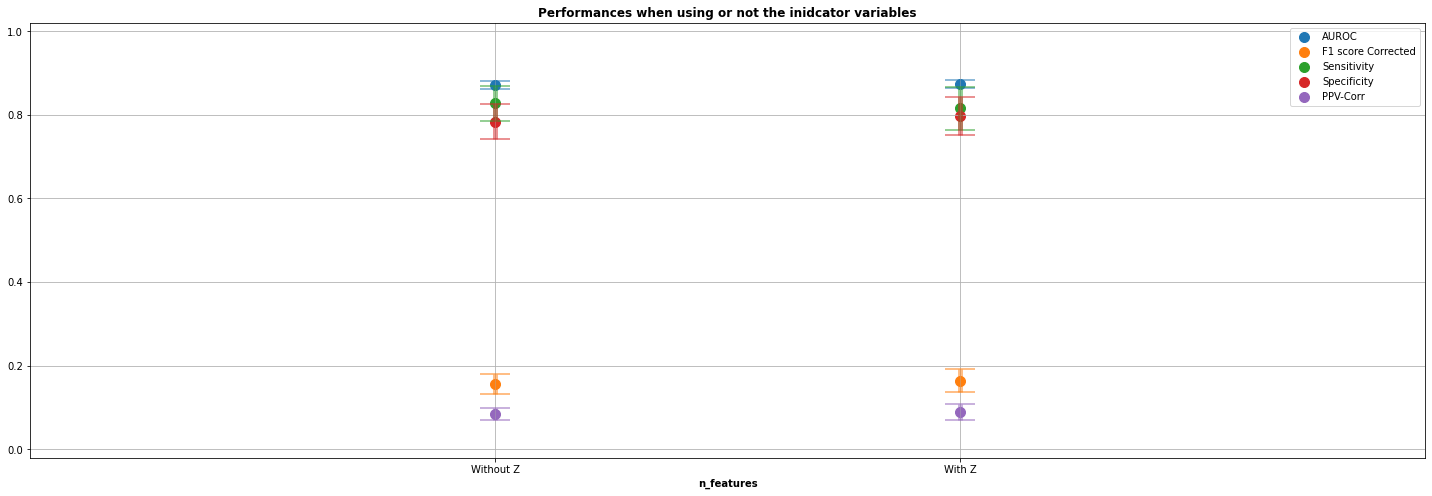

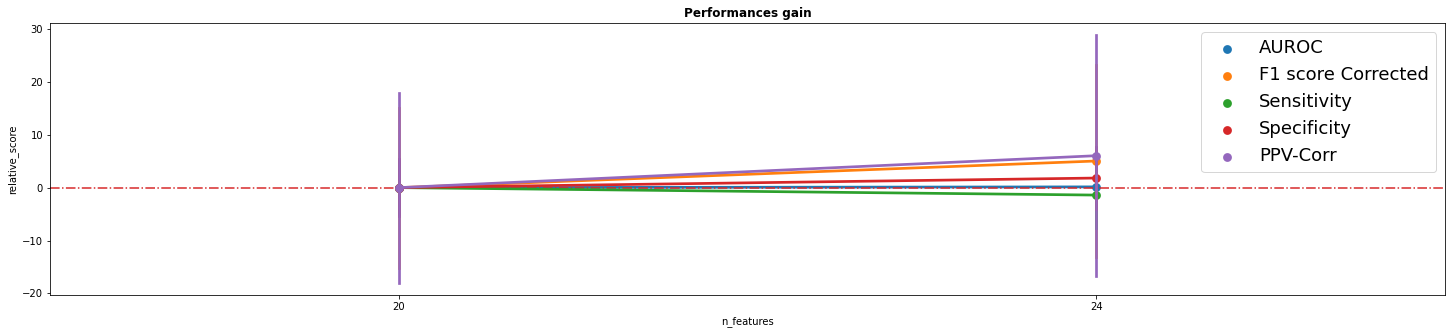

In [16]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'use_Z') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]

results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan
for idx, row in results.iterrows():
    baseline_score = results.loc[(results['n_features']==20) & (results['metric_name']==row['metric_name']), 'score'].mean()
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)/baseline_score*100

condition = 'n_features'
xtickslabels = ['Without Z', 'With Z']
plot_scatter_results(results, condition, xtickslabels)
    

**Conclusion**
- Using the additional indicator variables does not seem to improve the performances. 


## Influence of scaling the data

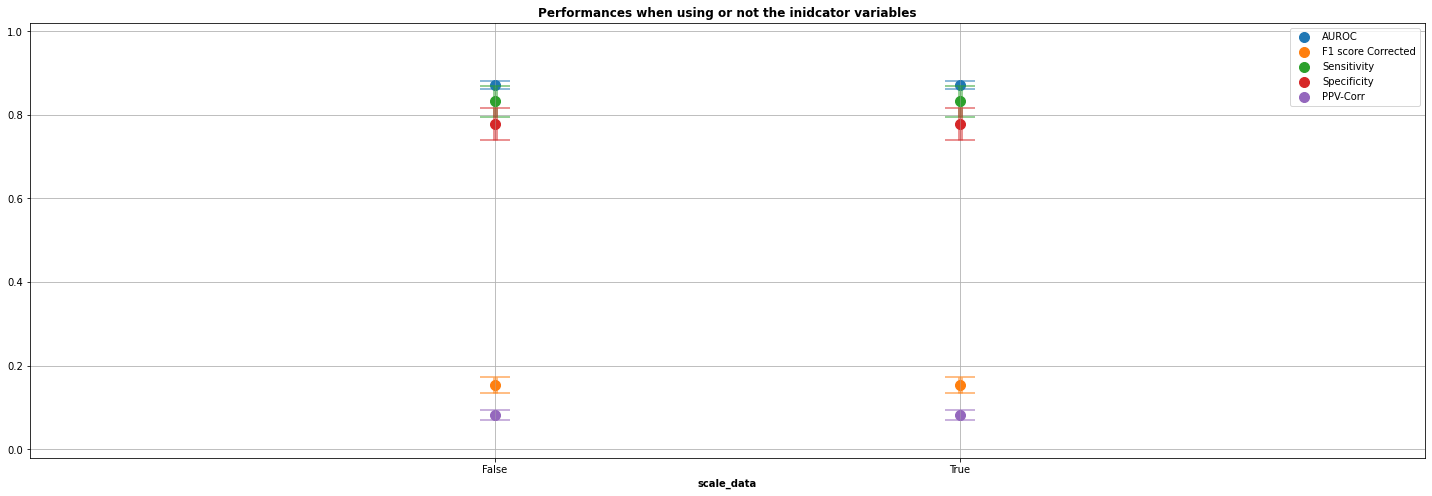

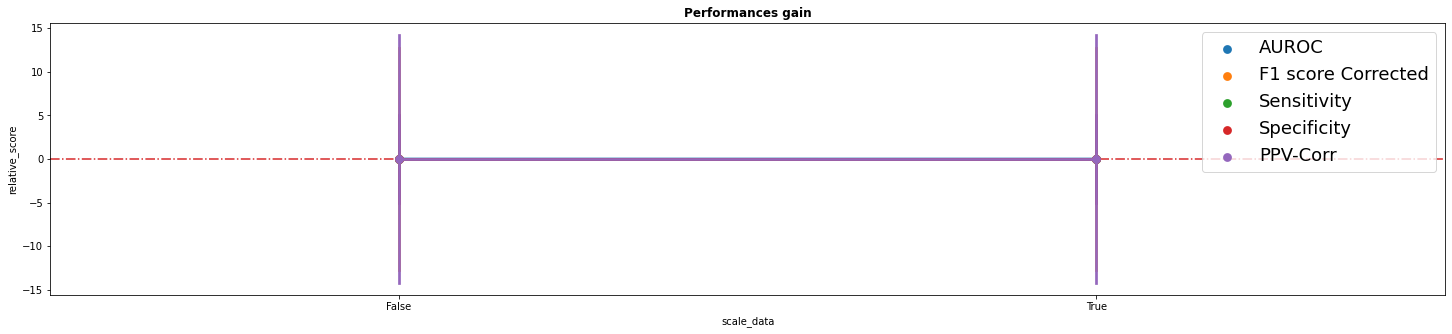

In [17]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'Scale Data') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]

results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan
for idx, row in results.iterrows():
    baseline_score = results.loc[(results['scale_data']==False) & (results['metric_name']==row['metric_name']), 'score'].mean()
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)/baseline_score*100

condition = 'scale_data'
plot_scatter_results(results, condition)
    

## Influence of the sampling method

500


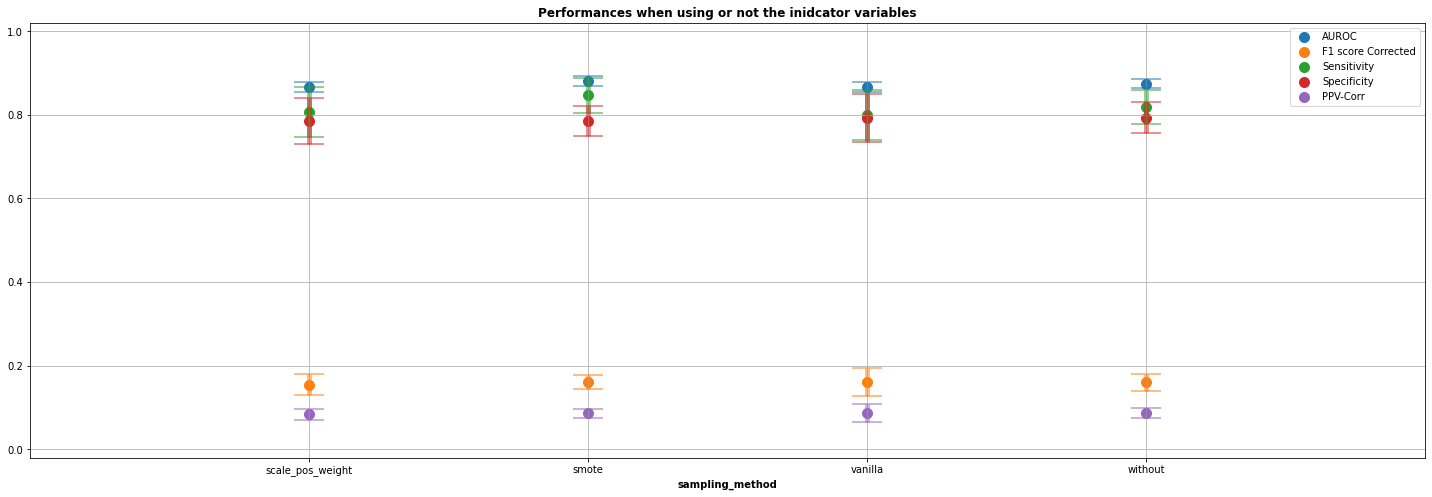

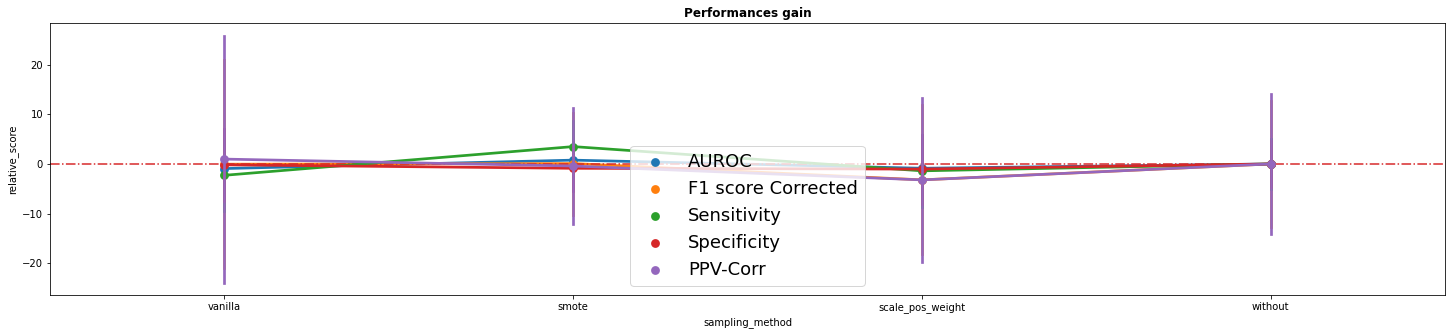

In [18]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'Sampling')& (results_df_vertical['metric_name'].isin(metrics_to_plot))]
print(len(results))
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    baseline_score = results.loc[(results['sampling_method']=='without') &(results['metric_name']==row['metric_name']), 'score'].mean()
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)/baseline_score*100
    
    
condition = 'sampling_method'
plot_scatter_results(results, condition, xtickslabels=None)
    

In [30]:
results.groupby([condition, 'metric_name']).describe()['score']

count     mean       std    min    25%    50%    75%    max
sampling_method  metric_name                                                                    
scale_pos_weight AUROC                25.0  0.86684  0.012429  0.840  0.858  0.868  0.876  0.889
                 F1 score Corrected   25.0  0.15484  0.024013  0.112  0.139  0.155  0.171  0.206
                 PPV-Corr             25.0  0.08324  0.014152  0.058  0.074  0.083  0.093  0.113
                 Sensitivity          25.0  0.80660  0.058705  0.673  0.776  0.796  0.857  0.898
                 Specificity          25.0  0.78464  0.055075  0.671  0.759  0.796  0.820  0.866
smote            AUROC                25.0  0.88112  0.011454  0.854  0.879  0.883  0.888  0.899
                 F1 score Corrected   25.0  0.16008  0.016411  0.125  0.147  0.160  0.175  0.191
                 PPV-Corr             25.0  0.08564  0.009987  0.063  0.078  0.086  0.093  0.106
                 Sensitivity          25.0  0.84652  0.041730  0.776  0.816  0.857  0.878  0.918
                 Specificity          25.0  0.78588  0.036094  0.689  0.762  0.790  0.808  0.848
vanilla          AUROC                25.0  0.86628  0.011936  0.836  0.862  0.869  0.876  0.883
                 F1 score Corrected   25.0  0.15988  0.033390  0.117  0.140  0.151  0.166  0.237
                 PPV-Corr             25.0  0.08684  0.021379  0.061  0.075  0.079  0.091  0.138
                 Sensitivity          25.0  0.79928  0.059502  0.673  0.776  0.816  0.837  0.878
                 Specificity          25.0  0.79140  0.057461  0.686  0.759  0.796  0.814  0.899
without          AUROC                25.0  0.87440  0.011143  0.851  0.868  0.877  0.882  0.895
                 F1 score Corrected   25.0  0.15996  0.020194  0.129  0.143  0.162  0.174  0.203
                 PPV-Corr             25.0  0.08600  0.012169  0.067  0.077  0.087  0.094  0.109
                 Sensitivity          25.0  0.81796  0.041255  0.714  0.796  0.816  0.857  0.878
                 Specificity          25.0  0.79284  0.037189  0.729  0.771  0.796  0.817  0.860

**Conclusion**
- Using scale_pos_weight


## Influence of the imputation technics

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (5).

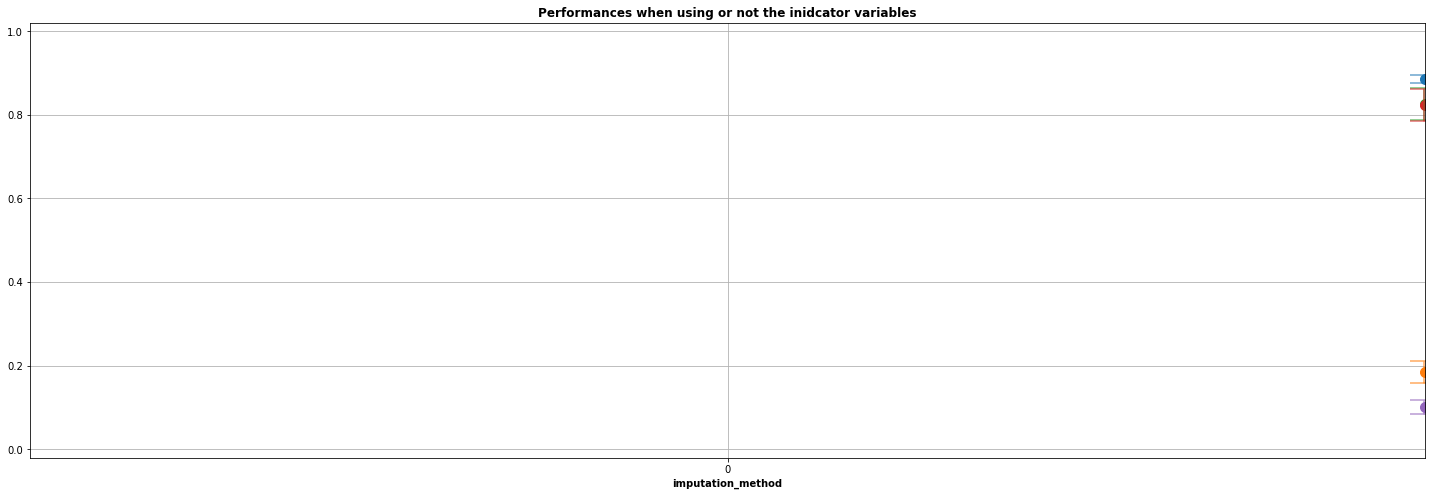

In [31]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'Imputation') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    baseline_score = results.loc[(results['imputation_method']=='without') &(results['metric_name']==row['metric_name']), 'score'].mean()
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)/baseline_score*100

order = ['without', 'constant', 'mean', 'knn', 'mice']


condition = 'imputation_method'
plot_scatter_results(results, condition, xtickslabels=None, order=order)
    

**Conclusion**
- Constant imputation seem to improve the performances. Since then it's more difficult to retrieve the role of missing data, we will keep no imputation for now, but once the model is selected we will do another try to see the performances improvement.


## Influence of lambda

Text(0.5, 1.0, 'Tree usage (ratio of maximum number of posible leaves)')

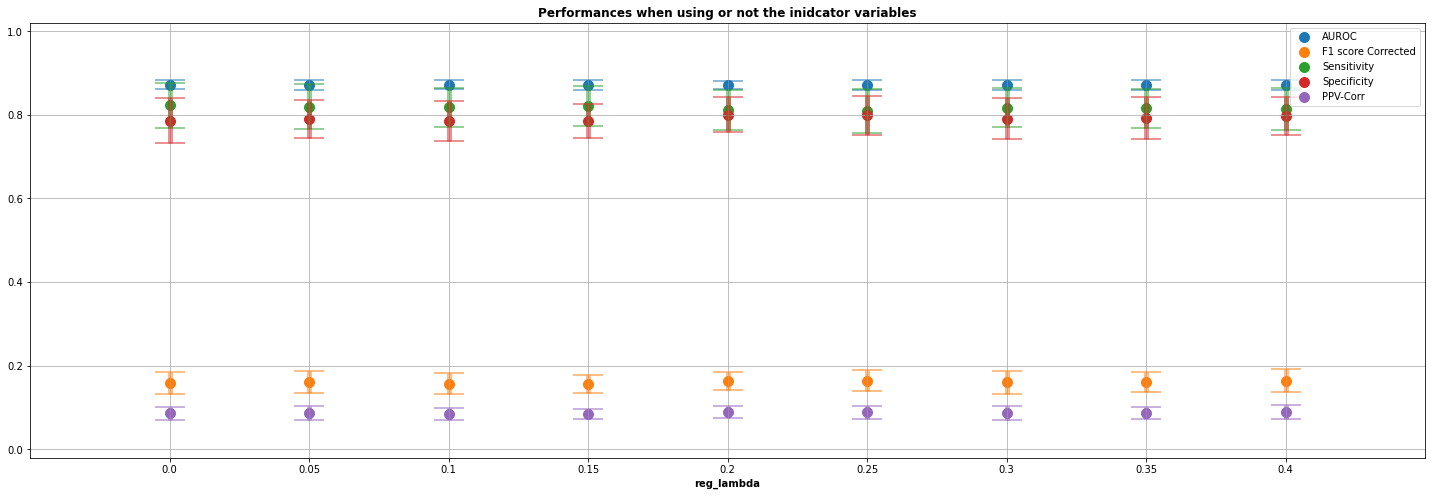

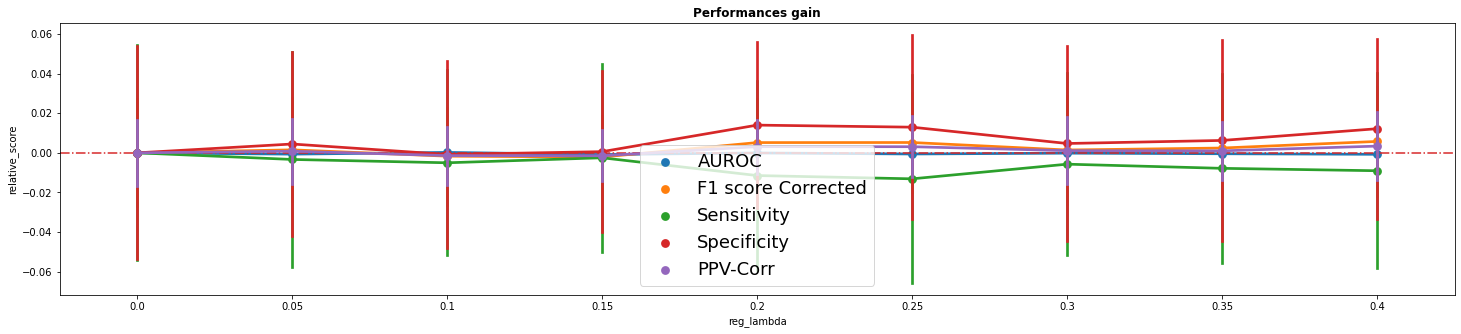

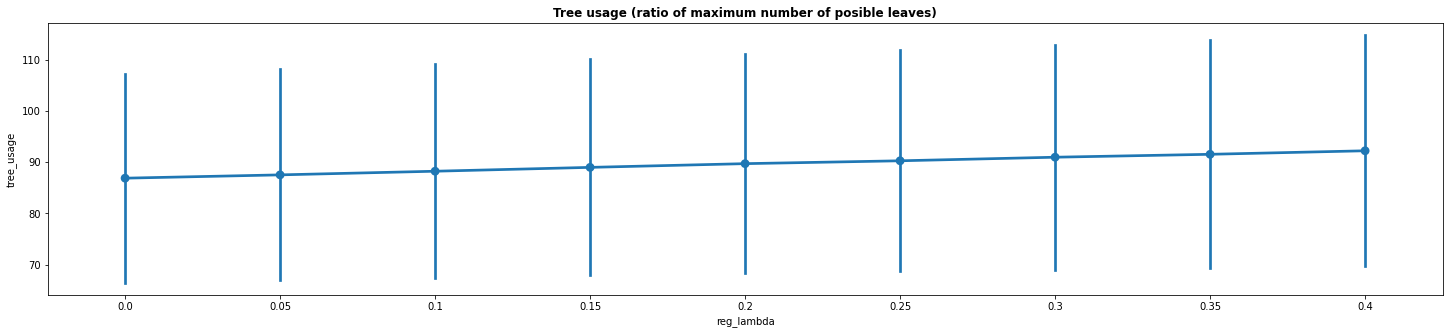

In [38]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'reg_lambda') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['reg_lambda']==0) &(results['metric_name']==row['metric_name']), 'score'].mean()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100


condition = 'reg_lambda'
plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False)
    
fig = plt.figure(figsize=(25, 5));ax = plt.gca()
ax = sns.pointplot(data=df[df['experiment_name']==condition], x=condition, y="tree_usage", ci='sd', linestyles='-', ax = ax)
ax.set_title("Tree usage (ratio of maximum number of posible leaves)", weight='bold')

In [40]:
results[results['metric_name'].isin(['AUROC'])].groupby([condition, 'metric_name']).describe()['score']

,,count,mean,std,min,25%,50%,75%,max
reg_lambda,metric_name,,,,,,,,
0.00,AUROC,50.0,0.87168,0.011015,0.843,0.86750,0.8750,0.87900,0.890
0.05,AUROC,50.0,0.87102,0.012369,0.842,0.86250,0.8735,0.88000,0.893
0.10,AUROC,50.0,0.87190,0.011504,0.847,0.86500,0.8730,0.88075,0.895
0.15,AUROC,50.0,0.87082,0.011326,0.838,0.86400,0.8720,0.88100,0.885
0.20,AUROC,50.0,0.87162,0.009642,0.844,0.86700,0.8740,0.87800,0.889
0.25,AUROC,50.0,0.87110,0.011244,0.841,0.86425,0.8730,0.87875,0.892
0.30,AUROC,50.0,0.87152,0.011583,0.844,0.86525,0.8730,0.87875,0.895
0.35,AUROC,50.0,0.87122,0.012258,0.835,0.86425,0.8740,0.88075,0.892
0.40,AUROC,50.0,0.87094,0.012719,0.839,0.86125,0.8730,0.87950,0.895


## Influence of the depth

Text(0.5, 1.0, 'Tree usage (ratio of maximum number of posible leaves)')

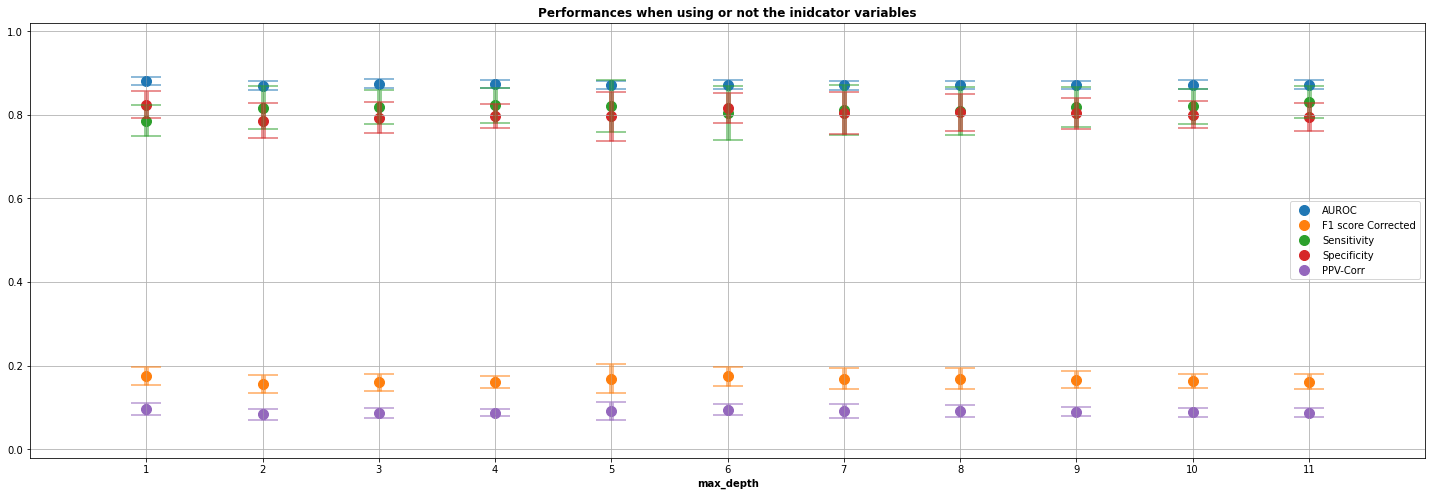

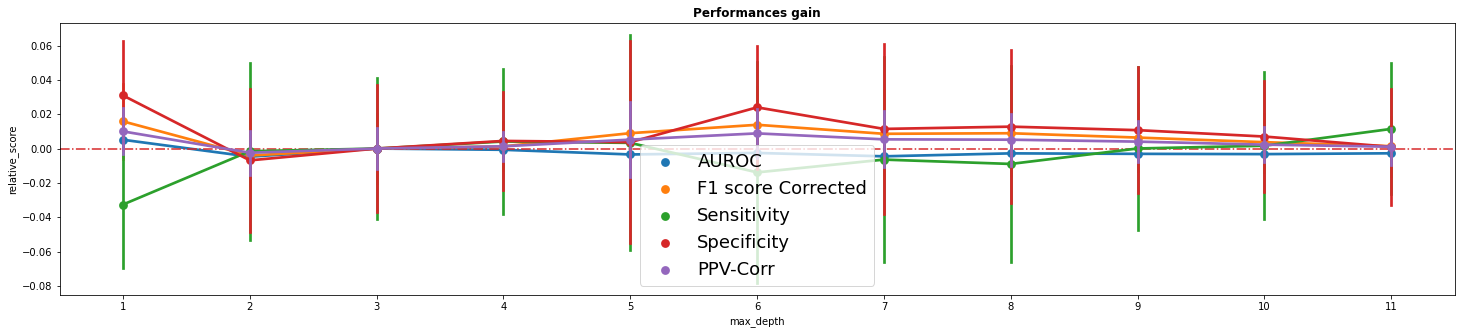

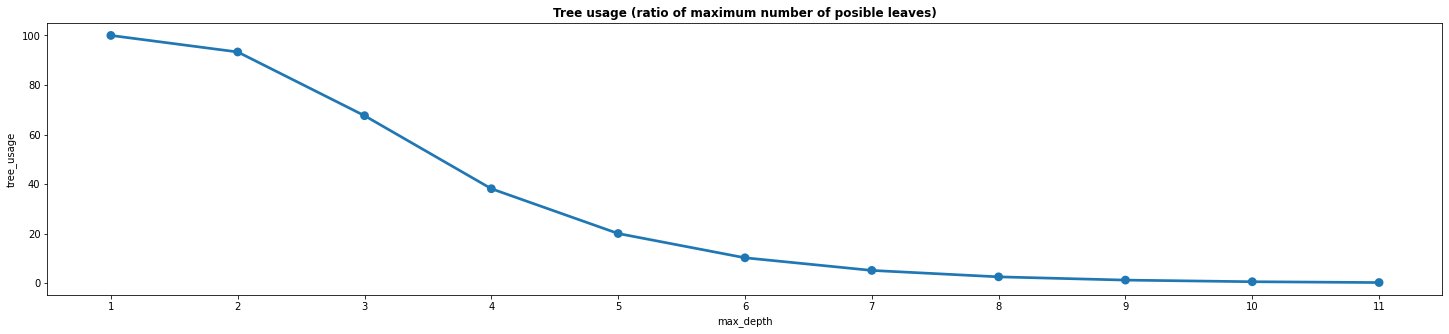

In [41]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'max_depth') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['max_depth']==3) &(results['metric_name']==row['metric_name']), 'score'].mean()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100


condition = 'max_depth'
plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False)
    
fig = plt.figure(figsize=(25, 5));ax = plt.gca()
ax = sns.pointplot(data=df[df['experiment_name']==condition], x=condition, y="tree_usage", ci='sd', linestyles='-', ax = ax)
ax.set_title("Tree usage (ratio of maximum number of posible leaves)", weight='bold')

## Influence of the gamma

Text(0.5, 1.0, 'Tree usage (ratio of maximum number of posible leaves)')

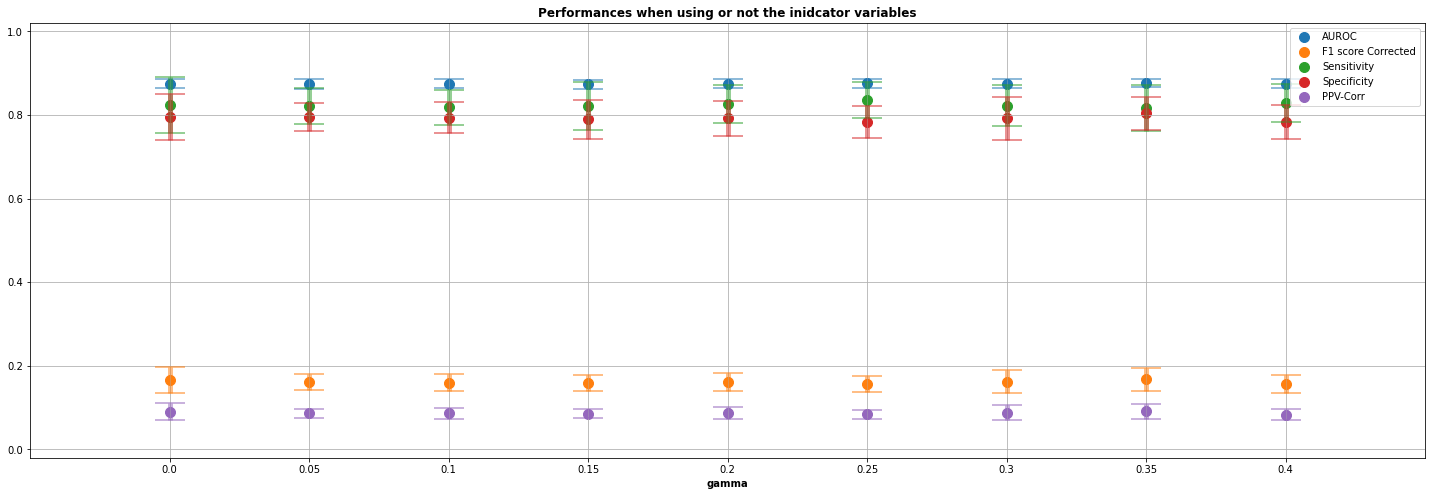

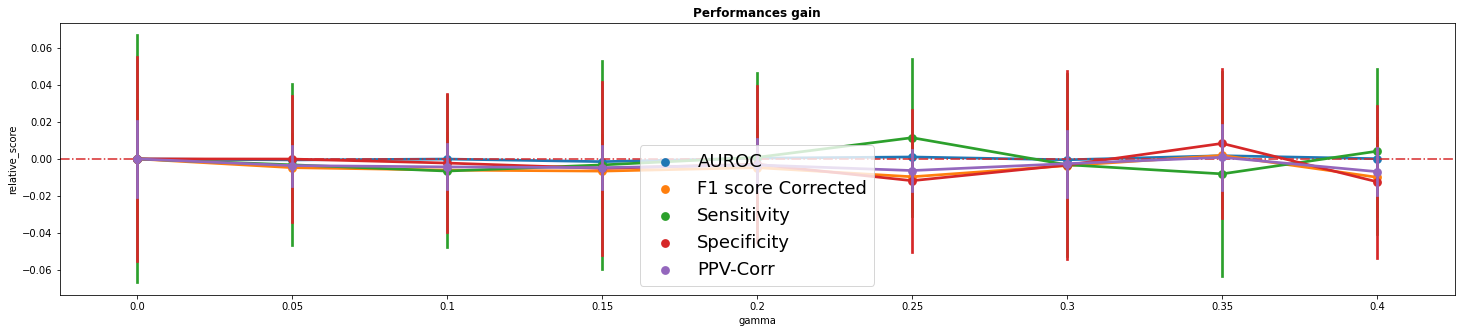

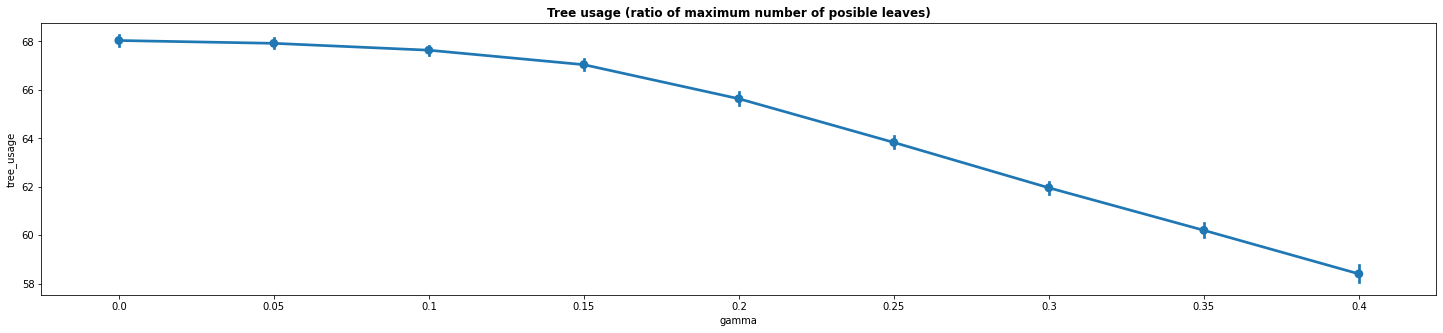

In [42]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'gamma') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['gamma']==0) &(results['metric_name']==row['metric_name']), 'score'].mean()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100


condition = 'gamma'
plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False)
    
fig = plt.figure(figsize=(25, 5));ax = plt.gca()
ax = sns.pointplot(data=df[df['experiment_name']==condition], x=condition, y="tree_usage", ci='sd', linestyles='-', ax = ax)
ax.set_title("Tree usage (ratio of maximum number of posible leaves)", weight='bold')

In [43]:
results[results['metric_name'].isin(['AUROC'])].groupby([condition, 'metric_name']).describe()['score']

,,count,mean,std,min,25%,50%,75%,max
gamma,metric_name,,,,,,,,
0.00,AUROC,25.0,0.87448,0.011008,0.850,0.867,0.878,0.882,0.893
0.05,AUROC,25.0,0.87392,0.011554,0.846,0.866,0.876,0.882,0.896
0.10,AUROC,25.0,0.87440,0.011143,0.851,0.868,0.877,0.882,0.895
0.15,AUROC,25.0,0.87300,0.010259,0.846,0.867,0.877,0.880,0.887
0.20,AUROC,25.0,0.87488,0.010199,0.846,0.871,0.877,0.880,0.893
0.25,AUROC,25.0,0.87552,0.010713,0.848,0.871,0.878,0.882,0.890
0.30,AUROC,25.0,0.87400,0.010743,0.851,0.865,0.876,0.882,0.891
0.35,AUROC,25.0,0.87620,0.010328,0.847,0.870,0.878,0.882,0.893
0.40,AUROC,25.0,0.87460,0.011109,0.845,0.870,0.877,0.882,0.889


## Influence of the learning rate

Text(0.5, 1.0, 'Tree usage (ratio of maximum number of posible leaves)')

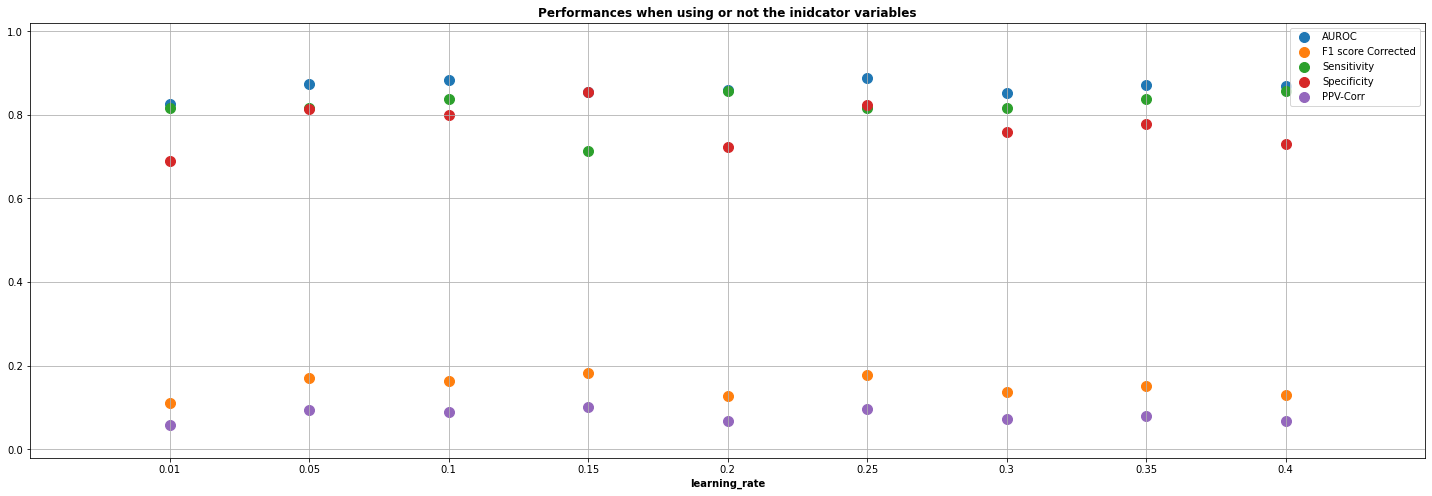

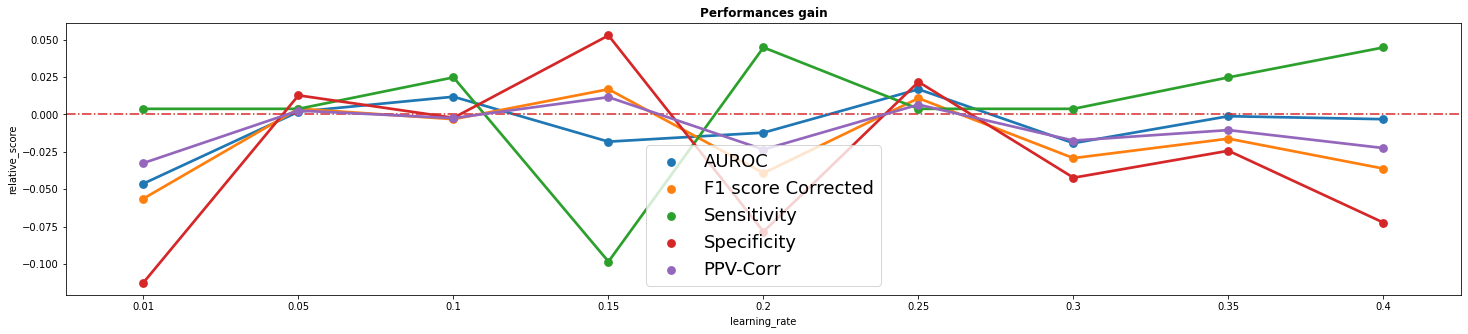

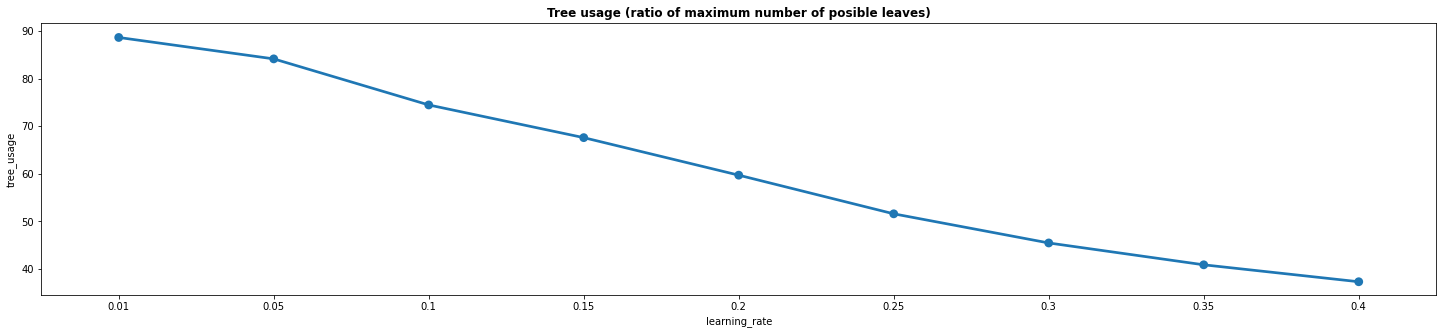

In [44]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'learning_rate') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['learning_rate']==.3) &(results['metric_name']==row['metric_name']), 'score'].mean()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100
    
results.drop_duplicates(subset=['experiment_name', 'learning_rate', 'metric_name'], inplace=True)

condition = 'learning_rate'
plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False)
    
fig = plt.figure(figsize=(25, 5));ax = plt.gca()
ax = sns.pointplot(data=df[df['experiment_name']==condition], x=condition, y="tree_usage", ci='sd', linestyles='-', ax = ax)
ax.set_title("Tree usage (ratio of maximum number of posible leaves)", weight='bold')

In [46]:
results[results['metric_name'].isin(['AUROC', 'Sensitivity'])].groupby([condition, 'metric_name']).describe()['score']

count   mean  std    min    25%    50%    75%    max
learning_rate metric_name                                                      
0.01          AUROC          1.0  0.825  NaN  0.825  0.825  0.825  0.825  0.825
              Sensitivity    1.0  0.816  NaN  0.816  0.816  0.816  0.816  0.816
0.05          AUROC          1.0  0.873  NaN  0.873  0.873  0.873  0.873  0.873
              Sensitivity    1.0  0.816  NaN  0.816  0.816  0.816  0.816  0.816
0.10          AUROC          1.0  0.883  NaN  0.883  0.883  0.883  0.883  0.883
              Sensitivity    1.0  0.837  NaN  0.837  0.837  0.837  0.837  0.837
0.15          AUROC          1.0  0.853  NaN  0.853  0.853  0.853  0.853  0.853
              Sensitivity    1.0  0.714  NaN  0.714  0.714  0.714  0.714  0.714
0.20          AUROC          1.0  0.859  NaN  0.859  0.859  0.859  0.859  0.859
              Sensitivity    1.0  0.857  NaN  0.857  0.857  0.857  0.857  0.857
0.25          AUROC          1.0  0.888  NaN  0.888  0.888  0.888  0.888  0.888
              Sensitivity    1.0  0.816  NaN  0.816  0.816  0.816  0.816  0.816
0.30          AUROC          1.0  0.852  NaN  0.852  0.852  0.852  0.852  0.852
              Sensitivity    1.0  0.816  NaN  0.816  0.816  0.816  0.816  0.816
0.35          AUROC          1.0  0.870  NaN  0.870  0.870  0.870  0.870  0.870
              Sensitivity    1.0  0.837  NaN  0.837  0.837  0.837  0.837  0.837
0.40          AUROC          1.0  0.868  NaN  0.868  0.868  0.868  0.868  0.868
              Sensitivity    1.0  0.857  NaN  0.857  0.857  0.857  0.857  0.857

## Influence of the n_estimators

Text(0.5, 1.0, 'Tree usage (ratio of maximum number of posible leaves)')

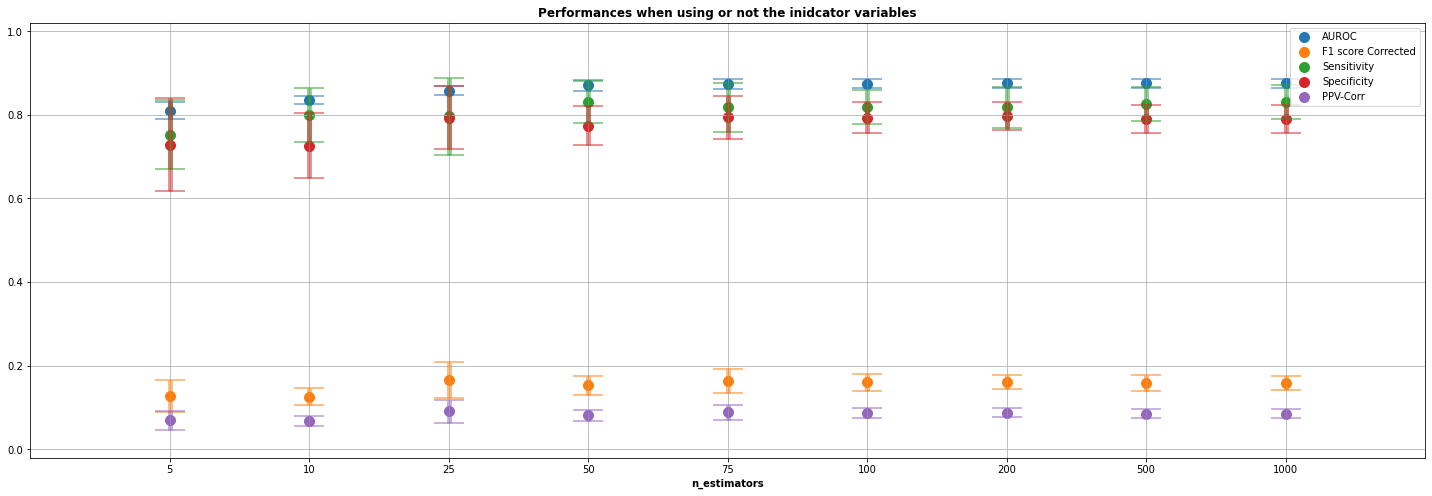

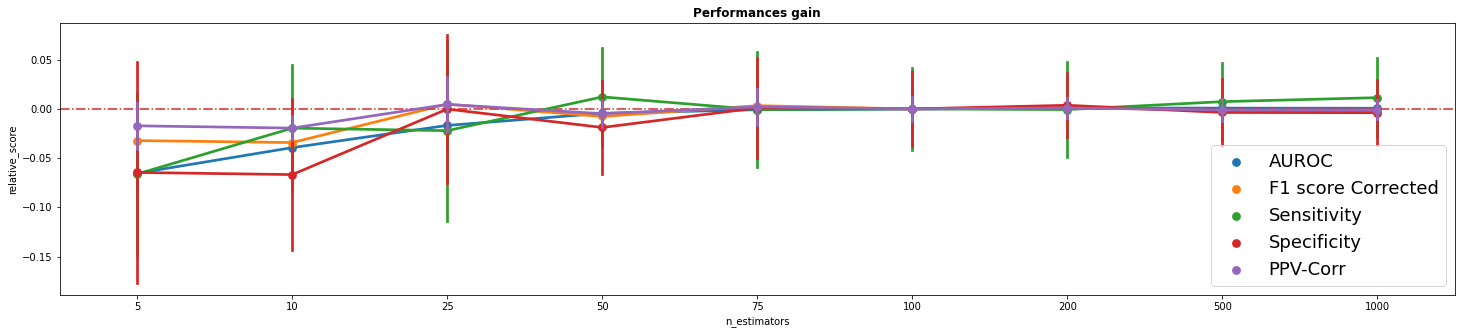

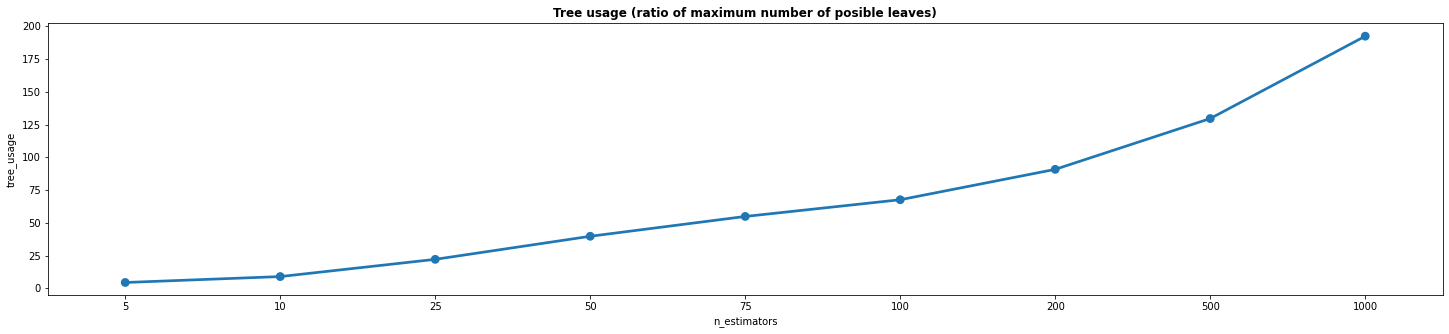

In [47]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'n_estimators') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['n_estimators']==100) &(results['metric_name']==row['metric_name']), 'score'].mean()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100
    
condition = 'n_estimators'
plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False)
    
fig = plt.figure(figsize=(25, 5));ax = plt.gca()
ax = sns.pointplot(data=df[df['experiment_name']==condition], x=condition, y="tree_usage", ci='sd', linestyles='-', ax = ax)
ax.set_title("Tree usage (ratio of maximum number of posible leaves)", weight='bold')

In [48]:
results[results['metric_name'].isin(['AUROC'])].groupby([condition, 'metric_name']).describe()['score']

,,count,mean,std,min,25%,50%,75%,max
n_estimators,metric_name,,,,,,,,
5,AUROC,25.0,0.80908,0.020524,0.767,0.802,0.811,0.816,0.844
10,AUROC,25.0,0.83508,0.009656,0.811,0.828,0.834,0.841,0.853
25,AUROC,25.0,0.85764,0.010507,0.830,0.854,0.856,0.863,0.878
50,AUROC,25.0,0.86996,0.012595,0.837,0.864,0.871,0.878,0.892
75,AUROC,25.0,0.87360,0.011098,0.849,0.868,0.874,0.881,0.896
100,AUROC,25.0,0.87440,0.011143,0.851,0.868,0.877,0.882,0.895
200,AUROC,25.0,0.87528,0.010526,0.854,0.867,0.876,0.884,0.894
500,AUROC,25.0,0.87524,0.010663,0.854,0.867,0.877,0.884,0.895
1000,AUROC,25.0,0.87508,0.010681,0.854,0.867,0.876,0.884,0.895


## Conclusions

**Conclusions**

- Use Z
- No scaling
- lambda 0.1
- gamma 0.1
- Max depth 3
- n_estimators 200
- constant imputation
- learning rate 0.15
- scale_pos_weight

467 administrations left.


,id
diagnosis,
0.0,417
1.0,50


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.859,0.543,0.926,0.276,0.986,0.614,0.146,0.614,0.289,0.779,0.406,0.82,0.775,0.304,0.078,0.973,0.18,0.696,0.027,41,323,94,9


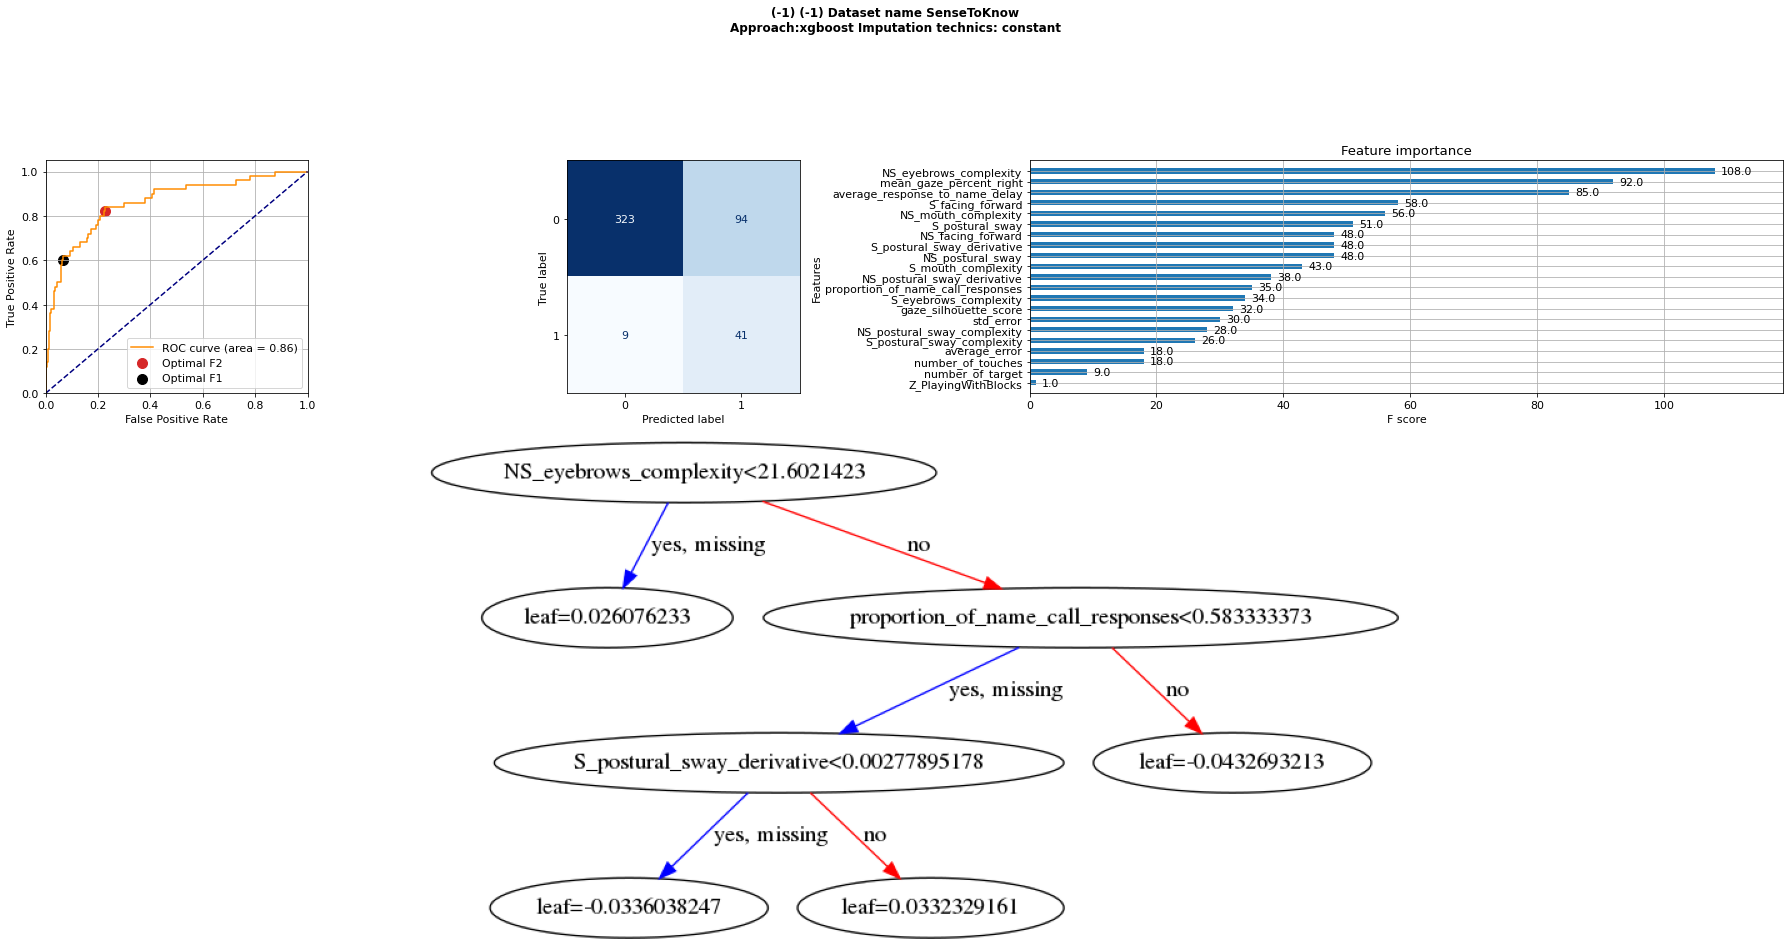

In [110]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}


df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='27_november', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'Multimodal All',
                  verbosity=1, 
                  save_experiment=False)

exp.fit_predict(num_cv='loocv')
exp.plot()

# Influence of calibration coefficient on the precision 

Since the positive class prevalence in the analyzed cohort might be different than the one in the population, the estimation of some performances metrics might be biased and lure scientists or decision makers. The precision estimates for instance can change drastically from the lab setting from the population implementation of a screening tools. This section aims at analyzing the evolution of the calibration factor $C(\pi)$ presented in (see [1]) in function of the study prevalence $\pi_{study}$.

$$\text{Precision}_{C} = \tfrac{TP}{TP + \tfrac{\pi_{lab}(1-\pi_{pop})}{\pi_{pop}(1-\pi_{lab})}FP}$$.

$$C(\pi_{lab}) =  \tfrac{\pi_{lab}(1-\pi_{pop})}{\pi_{pop}(1-\pi_{lab})} $$


[1] Siblini, W., Fréry, J., He-Guelton, L., Oblé, F., Wang, YQ. (2020). Master Your Metrics with Calibration. In: Berthold, M., Feelders, A., Krempl, G. (eds) Advances in Intelligent Data Analysis XVIII. IDA 2020. Lecture Notes in Computer Science(), vol 12080. Springer, Cham. https://doi.org/10.1007/978-3-030-44584-3_36

Text(0.5, 1.0, 'Evolution of the calibration coefficient in function of the study autism prevalence $\\pi_{study}$')

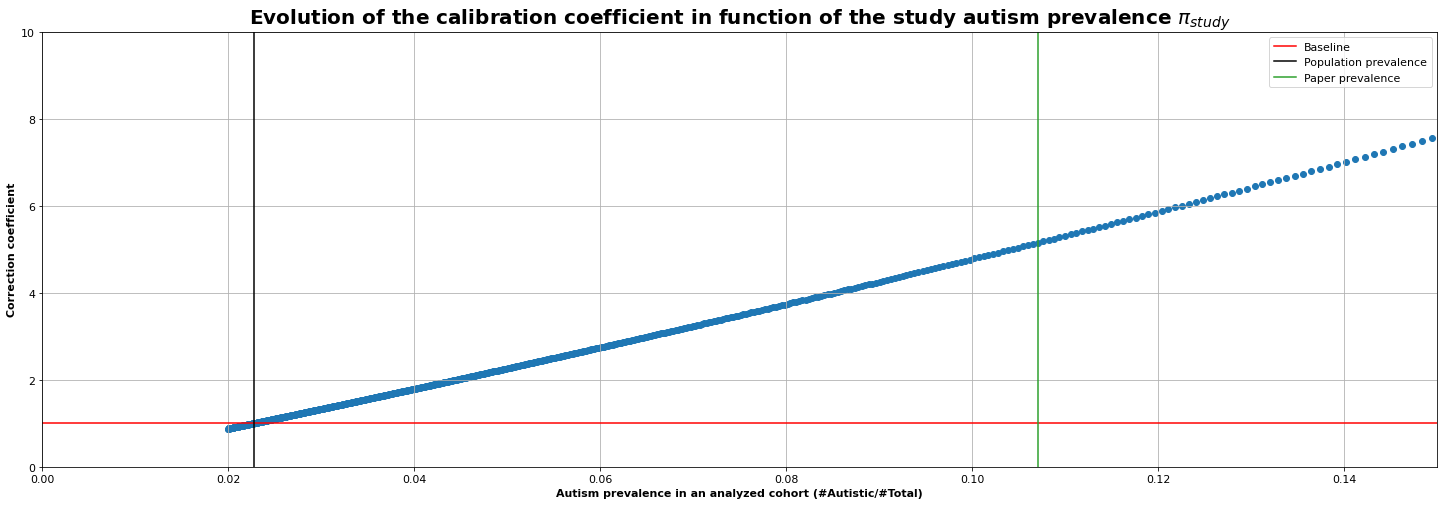

In [106]:
def coeff(pi):
    pi_0 = 1/44
    return (pi*(1-pi_0))/(pi_0*(1-pi))

pi_list = list(1/np.linspace(1, 50, 1000)) #From a prevalence of 1 (100% autistic) to a prevalence of 1/50 = 2%
coeff_list = [coeff(pi) for pi in pi_list]



fi(25, 8)
plt.scatter(np.array(pi_list), coeff_list)
plt.xlim([0, 0.15]);plt.ylim([0, 10])
plt.axhline(1, color='red', label='Baseline'); plt.ylabel("Correction coefficient", weight='bold');plt.xlabel("Autism prevalence in an analyzed cohort (#Autistic/#Total)", weight='bold')
plt.axvline(x=REFERENCE_IMBALANCE_RATIO, label='Population prevalence', color='k');plt.axvline(x=50/467, label='Paper prevalence', color='tab:green')
plt.legend();plt.grid()
plt.title("Evolution of the calibration coefficient in function of the study autism prevalence $\pi_{study}$", weight='bold', fontsize=20)